In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

In [17]:
X_train = np.load("../Data/X_train.npy", allow_pickle=True).T
X_test = np.load("../Data/X_test.npy", allow_pickle=True).T
y_train = np.load("../Data/y_train.npy", allow_pickle=True)
y_test = np.load("../Data/y_test.npy", allow_pickle=True)

print(X_train.shape)
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

print(X_train.shape)


(1955, 10199)
(1955, 3044)


In [3]:
def create_model(model_type, input_dim=None, **kwargs):
    if model_type == 'neural_network':
        inputs = Input(shape=(input_dim, ))
        x = Dense(64, input_dim=input_dim, activation='relu')(inputs)
        x = Dropout(0.5)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif model_type == 'svm':
        model = SVC(probability=True, **kwargs)
    elif model_type == 'xgboost':
        model = xgb.XGBClassifier(eval_metric='logloss', **kwargs)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model

In [4]:
def train_model(X_train, y_train, model_type, epochs=100, batch_size=32, validation_split=0.1, **kwargs):
    input_dim = X_train.shape[1]
    model = create_model(model_type, input_dim, **kwargs)
    
    if model_type in ['neural_network']:
        def lr_schedule(epoch):
            return 0.001 * (0.1 ** int(epoch / 10))
        #lr_scheduler = LearningRateScheduler(lr_schedule)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            validation_split=validation_split,
            #callbacks=[lr_scheduler],
            verbose=1  # Set to 0 for no output, 1 for progress bar, 2 for one line per epoch
        )
    else:
        # For non-TensorFlow models
        model.fit(X_train, y_train)
        history = None
    
    return model, history

In [5]:
def train_model_feature_selection(X_train, y_train, X_test, model_type, epochs=100, batch_size=32, validation_split=0.1, **kwargs):
    selector = VarianceThreshold()
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    # Select top k features
    k = min(250, X_train.shape[1])  # Ensure k is not larger than the number of features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    input_dim = X_train_selected.shape[1]
    model = create_model(model_type, input_dim=input_dim, **kwargs)
    if model_type in ['neural_network']:
        def lr_schedule(epoch):
            return 0.001 * (0.1 ** int(epoch / 10))
        #lr_scheduler = LearningRateScheduler(lr_schedule)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(
            X_train_selected, y_train,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            validation_split=validation_split,
            #callbacks=[lr_scheduler],
            verbose=1  # Set to 0 for no output, 1 for progress bar, 2 for one line per epoch
        )
    return model, history, X_test_selected
    
    

In [6]:
def plot_training_history(history, metrics=None):
    """
    Plot training history of a TensorFlow model.
    
    :param history: History object returned by model.fit()
    :param metrics: List of metrics to plot (optional). If None, plots all available metrics.
    """
    if not isinstance(history, dict):
        history = history.history

    epochs = range(1, len(next(iter(history.values()))) + 1)

    if metrics is None:
        metrics = [m for m in history.keys() if not m.startswith('val_')]

    plt.figure(figsize=(12, 4 * len(metrics)))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(len(metrics), 1, i)
        
        plt.plot(epochs, history[metric], 'bo-', label=f'Training {metric}')
        if f'val_{metric}' in history:
            plt.plot(epochs, history[f'val_{metric}'], 'ro-', label=f'Validation {metric}')
        
        plt.title(f'{metric.capitalize()} vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        
        if metric == 'loss':
            plt.yscale('log')  # Use log scale for loss

    plt.tight_layout()
    plt.show()

In [7]:
def test_model(model, X_test, y_test, model_type):
    """
    Test the model on the test set and return various performance metrics.
    """
    # Make predictions
    if model_type in ['neural_network']:
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Ensure y_pred and y_test are 1D arrays
    y_pred = np.ravel(y_pred)
    y_test = np.ravel(y_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Use zero_division parameter to handle undefined cases
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Only calculate AUC-ROC if there are two classes in the predictions
    unique_classes = np.unique(y_pred)
    if len(unique_classes) == 2:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc_roc = None
    
    # For TensorFlow models, also get the loss
    if model_type in ['neural_network']:
        loss = model.evaluate(X_test, y_test)[0]
    else:
        loss = None
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'loss': loss,
        'confusion_matrix': cm
    }
    
    # Print additional information
    print("Confusion Matrix:")
    print(cm)
    print(f"Unique predicted classes: {unique_classes}")
    print(f"Prediction shape: {y_pred.shape}")
    print(f"Prediction dtype: {y_pred.dtype}")
    print(f"Prediction first few values: {y_pred[:10]}")
    print(f"Prediction distribution: {np.bincount(y_pred.astype(int))}")
    print(f"True label shape: {y_test.shape}")
    print(f"True label dtype: {y_test.dtype}")
    print(f"True label first few values: {y_test[:10]}")
    print(f"True label distribution: {np.bincount(y_test.astype(int))}")
    
    return results

In [8]:
model, history = train_model(X_train, y_train, model_type='neural_network', epochs=100)

Epoch 1/100


/Users/calwetzel/.pyenv/versions/Edgevanta/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4398 - loss: 70083.4219 - val_accuracy: 0.7041 - val_loss: 10948.0068
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4722 - loss: 19182.1465 - val_accuracy: 0.4592 - val_loss: 3488.1260
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4477 - loss: 12068.0586 - val_accuracy: 0.5714 - val_loss: 53.7018
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4546 - loss: 5914.1978 - val_accuracy: 0.4082 - val_loss: 99.0404
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4876 - loss: 3050.3909 - val_accuracy: 0.6531 - val_loss: 12.3469
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5374 - loss: 2648.3345 - val_accuracy: 0.5765 - val_loss: 22.1212
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 1457.7936 - val_accuracy: 0.3010 - val_loss: 6.2449
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5691 - loss: 703.0023 -

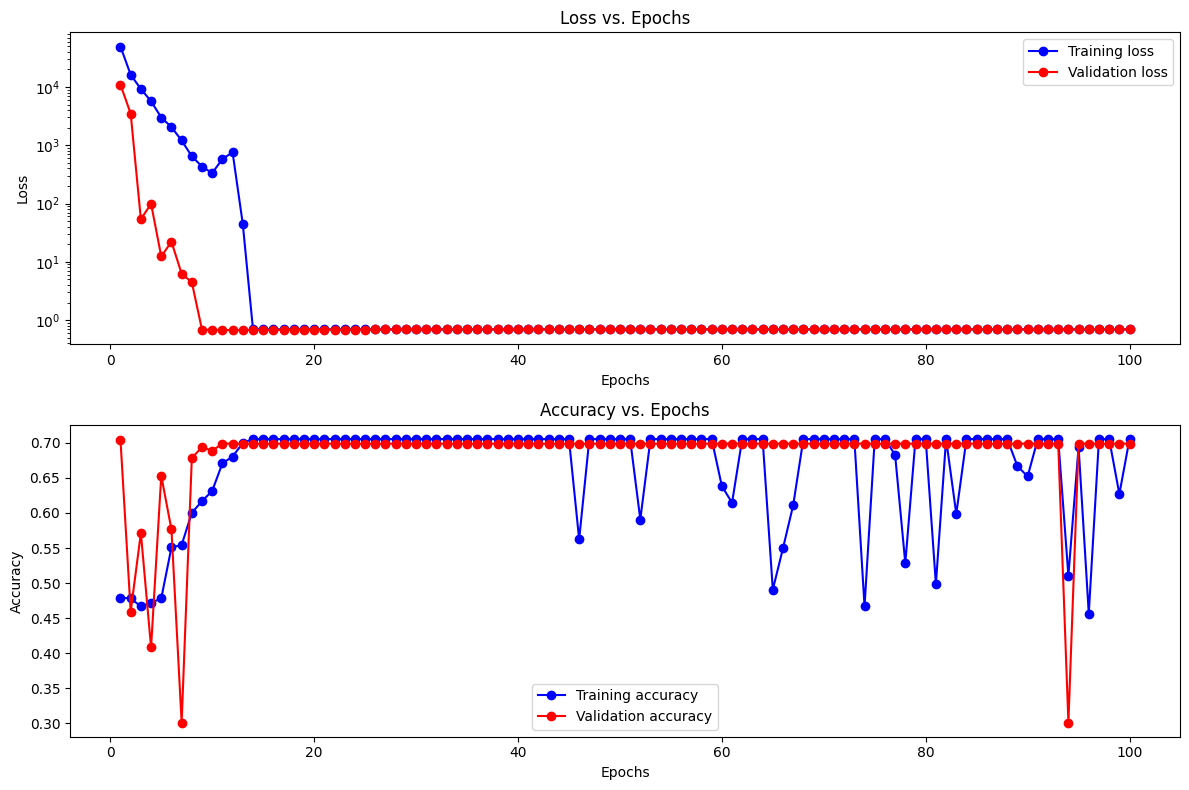

In [9]:
plot_training_history(history, metrics=['loss', 'accuracy'])

In [10]:
test_results = test_model(model, X_test, y_test, model_type='neural_network')
for metric, value in test_results.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7129 - loss: 0.6921
Confusion Matrix:
[[158   0]
 [ 59   0]]
Unique predicted classes: [0]
Prediction shape: (217,)
Prediction dtype: int64
Prediction first few values: [0 0 0 0 0 0 0 0 0 0]
Prediction distribution: [217]
True label shape: (217,)
True label dtype: float16
True label first few values: [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
True label distribution: [158  59]
accuracy: 0.728110599078341
precision: 0.0
recall: 0.0
f1_score: 0.0
auc_roc: None
loss: 0.6920018792152405


In [11]:
model, history, X_test_feature_selection = train_model_feature_selection(X_train, y_train, X_test, model_type='neural_network', epochs=250)

Epoch 1/250


/Users/calwetzel/.pyenv/versions/Edgevanta/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4911 - loss: 20355.2012 - val_accuracy: 0.6990 - val_loss: 356.8671
Epoch 2/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.5204 - loss: 8802.2852 - val_accuracy: 0.6990 - val_loss: 475.2604
Epoch 3/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.4838 - loss: 4195.9570 - val_accuracy: 0.3010 - val_loss: 88.0076
Epoch 4/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.4883 - loss: 1899.9526 - val_accuracy: 0.6990 - val_loss: 2.0307
Epoch 5/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.4861 - loss: 877.9033 - val_accuracy: 0.3010 - val_loss: 2.2939
Epoch 6/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.5036 - loss: 466.2012 - val_accuracy: 0.3010 - val_loss: 9.2533
Epoch 7/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.4577 - loss: 425.9919 - val_accuracy: 0.6990 - val_loss: 2.9141
Epoch 8/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.4648 - loss: 285.581

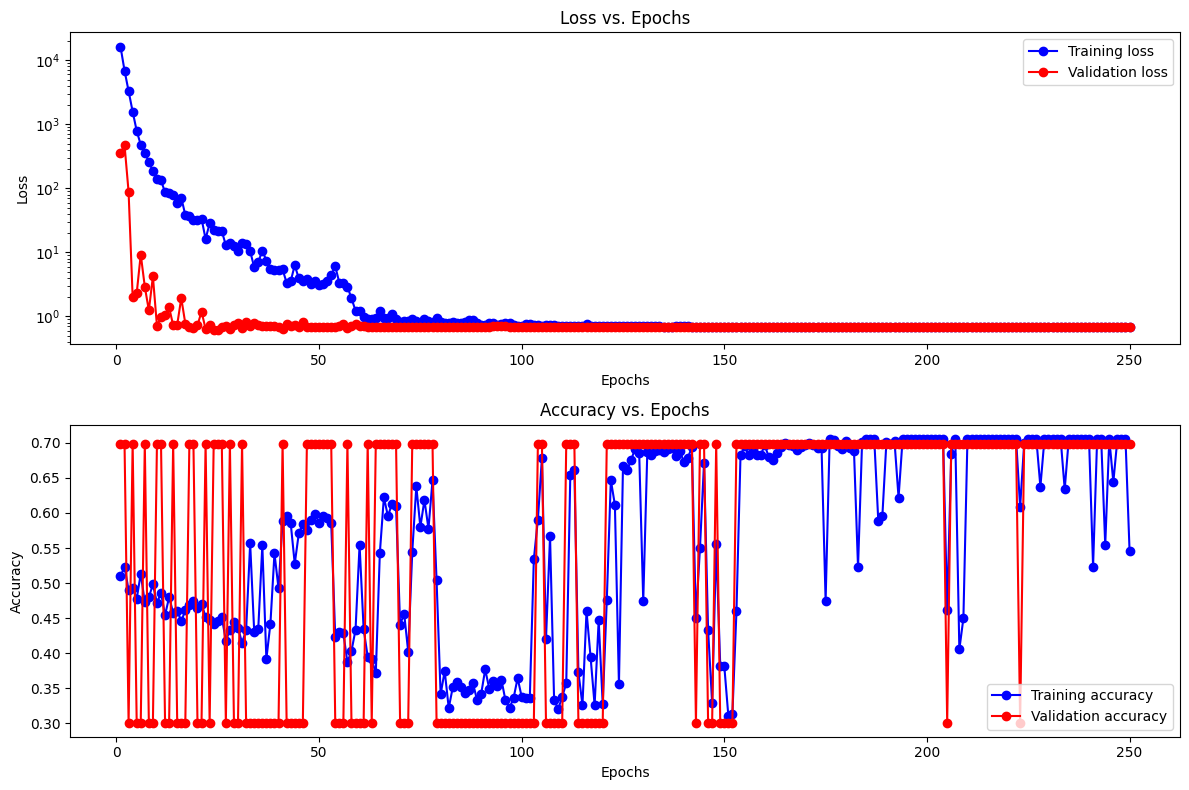

In [12]:
plot_training_history(history, metrics=['loss', 'accuracy'])

In [13]:
test_results = test_model(model, X_test_feature_selection, y_test, model_type='neural_network')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.7129 - loss: 0.6928
Confusion Matrix:
[[158   0]
 [ 59   0]]
Unique predicted classes: [0]
Prediction shape: (217,)
Prediction dtype: int64
Prediction first few values: [0 0 0 0 0 0 0 0 0 0]
Prediction distribution: [217]
True label shape: (217,)
True label dtype: float16
True label first few values: [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
True label distribution: [158  59]
accuracy: 0.728110599078341
precision: 0.0
recall: 0.0
f1_score: 0.0
auc_roc: None
loss: 0.6928072571754456
confusion_matrix: [[158   0]
 [ 59   0]]


In [14]:
model, history = train_model(X_train, y_train, model_type='xgboost', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='xgboost')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[132  26]
 [ 44  15]]
Unique predicted classes: [0 1]
Prediction shape: (217,)
Prediction dtype: int64
Prediction first few values: [0 1 1 1 0 0 0 0 0 0]
Prediction distribution: [176  41]
True label shape: (217,)
True label dtype: float16
True label first few values: [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
True label distribution: [158  59]
accuracy: 0.6774193548387096
precision: 0.36585365853658536
recall: 0.2542372881355932
f1_score: 0.3
auc_roc: 0.6124758635485947
loss: None
confusion_matrix: [[132  26]
 [ 44  15]]


In [15]:
model, history = train_model(X_train, y_train, model_type='random_forest', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='random_forest')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[145  13]
 [ 51   8]]
Unique predicted classes: [0. 1.]
Prediction shape: (217,)
Prediction dtype: float16
Prediction first few values: [0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
Prediction distribution: [196  21]
True label shape: (217,)
True label dtype: float16
True label first few values: [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
True label distribution: [158  59]
accuracy: 0.7050691244239631
precision: 0.38095238095238093
recall: 0.13559322033898305
f1_score: 0.2
auc_roc: 0.6217013516412787
loss: None
confusion_matrix: [[145  13]
 [ 51   8]]


In [16]:
model, history = train_model(X_train, y_train, model_type='svm', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='svm')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[158   0]
 [ 59   0]]
Unique predicted classes: [0.]
Prediction shape: (217,)
Prediction dtype: float16
Prediction first few values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction distribution: [217]
True label shape: (217,)
True label dtype: float16
True label first few values: [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
True label distribution: [158  59]
accuracy: 0.728110599078341
precision: 0.0
recall: 0.0
f1_score: 0.0
auc_roc: None
loss: None
confusion_matrix: [[158   0]
 [ 59   0]]
